In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import random

In [3]:
data = {}
fname = f'results/arithmetic/addition_multiplication_mixed_small_numbers_results_gpt-4.json'
with open(fname, 'r') as infile:
#     data["gpt-4"] = json.load(infile)["summary"]
    data = json.load(infile)
# with open(f'results/Bamboogle_new_prompt_results_2gpt-3.5-turbo.json', 'r') as infile:
#     data["gpt-3.5-turbo"] = json.load(infile)["summary"]

In [4]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(str(s)))))

def extract_answer(generated):
    generated = generated.lower()
    if 'final answer:' in generated:
        after_colon = generated.split('final answer:')[-1]
        if "\n" in after_colon:
            after_colon = after_colon.split("\n")[0]
    elif ":" in generated:
        after_colon = generated.split(':')[-1]
        if "\n" in after_colon:
            after_colon = after_colon.split("\n")[0]
    else:
        after_colon = generated
    return normalize_answer(after_colon)

In [49]:
for test, results in data.items():
    # Initialize the summary counts
    summary_counts = {
        'unprompted_correct': 0,
        'direct_answer_correct': 0,
        'unprompted_CEM_correct': 0,
        'direct_answer_CEM_correct': 0,
        'chain_of_thought_correct': 0,
        'chain_of_thought_CEM_correct': 0
    }
    
    for question_result in results['per_question_results']:
        for answer_type in ['unprompted', 'direct_answer', 'chain_of_thought']:
            # Extract and clean the answer from the returned field
            normalized_answer = normalize_answer(question_result[answer_type]['returned'])
            extracted_answer = extract_answer(question_result[answer_type]['returned'])

            # Always re-evaluate the is_right_CEM assignment
            question_result[answer_type]['is_right_CEM'] = str(question_result[answer_type]['answer']) in str(normalized_answer)
            # Increase the correct CEM count if the answer is correct
            if question_result[answer_type]['is_right_CEM']:
                summary_counts[answer_type + '_CEM_correct'] += 1

            # Re-evaluate the is_right assignment
            if answer_type == 'unprompted':
                question_result[answer_type]['is_right'] = question_result[answer_type]['is_right_CEM']
            else:
                question_result[answer_type]['is_right'] = False
                try:
                    # Ignore possible parse error
                    question_result[answer_type]['is_right'] = int(extracted_answer) == question_result[answer_type]['answer']
                except Exception as e:
                    print(e)
                    print(question_result[answer_type])

            # Increase the correct count if the answer is correct
            if question_result[answer_type]['is_right']:
                summary_counts[answer_type + '_correct'] += 1

    # Update the summary counts in the results
    results['summary'] = summary_counts

# Save the corrected data to a new JSON file
with open(fname, 'w') as file:
    json.dump(data, file, indent=4)


invalid literal for int() with base 10: ''
{'question': '15 * 19 + 11 + 7 + 0', 'prompt': 'Answer the following math problem, showing each step and stating your final answer in the form "final answer: <number>" on a new line. 15 * 19 + 11 + 7 + 0 =', 'answer': 303, 'returned': "To solve this problem, follow the order of operations (PEMDAS), which stands for Parentheses, Exponents, Multiplication and Division (from left to right), and Addition and Subtraction (from left to right).\n\nHere's a step-by-step solution:\n\n1. First, perform the multiplication: \n   15 * 19 = 285\n\n2. Then, perform the addition from left to right: \n   285 + 11 = 296\n   296 + 7 = 303\n\n3. As for the + 0, adding zero to any number doesn't change the number, so we can ignore it.\n\nFinal answer:\n303", 'is_right': False, 'is_right_CEM': True}
invalid literal for int() with base 10: '139 127 12'
{'question': '15 + 11 + 15 + 10 + 19 * 4 + 12', 'prompt': 'Answer the following math problem, showing each step and

In [5]:
prompt_types = {
    "unprompted": "", 
    "chain_of_thought": "Answer the following math problem, showing each step and stating your final answer in the form \"final answer: <number>\" on a new line.", 
    "direct_answer": "Answer the following math problem, final answer (number) only, NO WORDS. "
}

In [6]:
results_file = f'results/arithmetic/addition_multiplication_mixed_small_numbers_results_gpt-4.json'
results_file

def save():
    with open(results_file, 'w') as outfile:
        json.dump(data, outfile, ensure_ascii=False, indent=4)
save()

In [26]:
data["results_10_operators"]["per_question_results"][0].keys()

dict_keys(['unprompted', 'chain_of_thought', 'direct_answer'])

In [9]:
data2 = data["results_10_operators"]["per_question_results"]
len(data2)

100

In [45]:
seen = set()
unique = [x for x in data2 if x["unprompted"]['question'] not in seen and not seen.add(x["unprompted"]['question'])]
len(unique)

100

In [46]:
data["results_10_operators"]["per_question_results"] = unique

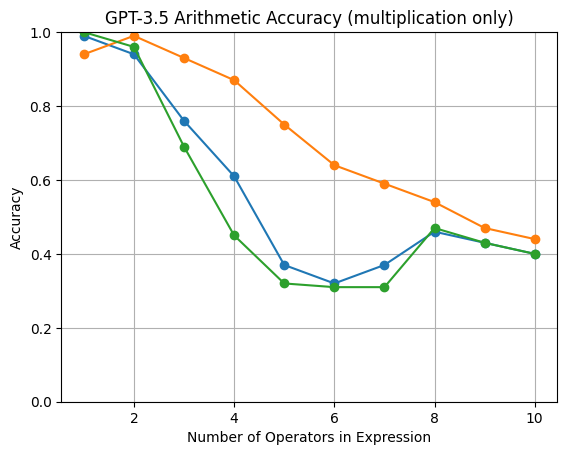

In [60]:
import matplotlib.pyplot as plt
import json

# models = ['gpt-3.5-turbo']
models = ['gpt-3.5-turbo']


def get_data(category):
    accuracies = dict()
    for model in models:
        accuracies[model] = dict()
        with open(f'results/arithmetic/{category}_results_{model}.json') as f:
            data = json.load(f)
        x = list(range(1, len(data) + 1))  # Number of operators
        for prompt_type in prompt_types.keys():
            accuracies[model][prompt_type] = [value['summary'][f'{prompt_type}_correct'] / 100 for value in list(data.values())]
    return x, accuracies

# Get data from JSON files
operator_counts_addition, addition_only_accuracies = get_data('addition_only_small_numbers')
operator_counts_multiplication, multiplication_only_accuracies = get_data('multiplication_only_small_numbers')
operator_counts_mixed, mixed_accuracies = get_data('addition_multiplication_mixed_small_numbers')

def plot_all_types_one_prompt(prompt_type, model):

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(operator_counts_multiplication, multiplication_only_accuracies[model][prompt_type], marker='o', label=f'* only')
    plt.plot(operator_counts_addition, addition_only_accuracies[model][prompt_type], marker='o', label=f'+ only')
    plt.plot(operator_counts_mixed, mixed_accuracies[model][prompt_type], marker='o', label=f'+ only')

    plt.xlabel('Number of Operators')
    plt.ylabel('Correct Answers (%)')
    plt.title(f'Accuracy vs Number of Operations ({prompt_type})')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set the y-axis limits
    plt.show()

def plot_all_prompts_one_type(operator_counts, accuracies, type, model):
    # line_styles = ['-', '--', '-.', ':']  # different line styles
    plt.figure()

    for prompt_type in prompt_types:
        plt.plot(operator_counts, accuracies[model][prompt_type], marker='o', label=f'{prompt_type}')

    plt.xlabel('Number of Operators in Expression')
    plt.ylabel('Accuracy')
    plt.title(f'{"GPT-3.5" if model == "gpt-3.5-turbo" else "GPT-4"} Arithmetic Accuracy ({type})')
    # plt.legend()
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.grid(True)
    plt.ylim(0, 1)  # Set the y-axis limits
    plt.show()

plot_all_prompts_one_type(operator_counts_mixed, multiplication_only_accuracies, "multiplication only", "gpt-3.5-turbo")



In [5]:

# Load data from JSON files
# models = ["curie", "davinci", "text-davinci-001", "text-davinci-002", "text-davinci-003", "gpt-3.5-turbo", "gpt-4"]
models = ["gpt-3.5-turbo"]

dataset_size = 125

data = {}
# with open(f'results/Bamboogle_results_gpt-4.json', 'r') as infile:
#     data["gpt-4"] = json.load(infile)["summary"]
# with open(f'results/Bamboogle_new_prompt_results_2gpt-3.5-turbo.json', 'r') as infile:
#     data["gpt-3.5-turbo"] = json.load(infile)["summary"]



for model in models:
    with open(f'results/CC_clean_results_{model}.json', 'r') as infile:
        data[model] = json.load(infile)["summary"]
        print(data[model].keys())

def plot_accuracies(accuracies, match_type):
    bar_width = 0.1
    x = np.arange(len(models))

    fig, ax = plt.subplots()

    for i, prompt_type in enumerate(prompt_types):
        accuracy = accuracies[prompt_type]
        ax.bar(x + (i - (len(prompt_types) - 1) / 2) * bar_width, accuracy, width=bar_width, label=f'{prompt_type} correct')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    # ax.set_title(f'Bamboogle Performance ({match_type})')
    ax.set_title(f'Bamboogle Performance')

    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=8)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    # for i, model in enumerate(models):
    #     difference = (accuracies[f"both_subquestions"][i] - accuracies[f"empty"][i]) / (accuracies[f"both_subquestions"][i]+.01) * 100
    #     y_start = accuracies[f"empty"][i]
    #     y_end = accuracies[f"both_subquestions"][i]
    #     x_pos = x[i] - 4 * 0.1 / 2
    #     ax.vlines(x_pos, y_start, y_end, linestyle='dotted', color='black')
    #     ax.annotate(f'{difference:.1f}%', xy=(x_pos, (y_start + y_end) / 2), fontsize=8, color='black', ha='right')


    plt.plot()



# Calculate accuracy for each prompt type and model
accuracies = {}
for match_type in ["EM", "CEM", "GPT_opinion"]:
    accuracies[match_type] = {}
    for prompt_type in prompt_types:
        key = f"{prompt_type}_correct_{match_type}"
        accuracies[match_type][prompt_type] = [data[model][key] / dataset_size for model in models]

    plot_accuracies(accuracies[match_type], match_type)







dict_keys(['empty_correct_EM', 'self_ask_two_hop_zero_shot_correct_EM', 'direct_answer_correct_EM', 'self_ask_correct_EM', 'empty_correct_CEM', 'self_ask_two_hop_zero_shot_correct_CEM', 'direct_answer_correct_CEM', 'self_ask_correct_CEM', 'empty_correct_GPT_opinion', 'self_ask_two_hop_zero_shot_correct_GPT_opinion', 'direct_answer_correct_GPT_opinion', 'self_ask_correct_GPT_opinion', 'both_subquestions_correct_CEM', 'both_subquestions_correct_EM', 'both_subquestions_correct_GPT_opinion'])
dict_keys(['empty_correct_EM', 'self_ask_two_hop_zero_shot_correct_EM', 'direct_answer_correct_EM', 'chain_of_thought_correct_EM', 'self_ask_correct_EM', 'empty_correct_CEM', 'self_ask_two_hop_zero_shot_correct_CEM', 'direct_answer_correct_CEM', 'chain_of_thought_correct_CEM', 'self_ask_correct_CEM', 'empty_correct_GPT_opinion', 'self_ask_two_hop_zero_shot_correct_GPT_opinion', 'direct_answer_correct_GPT_opinion', 'chain_of_thought_correct_GPT_opinion', 'self_ask_correct_GPT_opinion', 'both_subquestio

KeyError: 'self_ask_zero_shot_correct_EM'